In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
#importing required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import TextBlob
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import rcParams
from sklearn.decomposition import PCA
import seaborn as sns
import gensim
import gensim.downloader as api
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
#reading the dataset
df = pd.read_csv('/content/drive/MyDrive/MI/data/toxigen.csv')
df.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method
0,b'asians are trying to take over the world wit...,asian,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references asian,uses positive stereotyping,5.0,5.0,5.0,human,hate,TopK
1,b'i have never seen a hotter lineup in my life...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,NaN,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,TopK
2,b'muslims deseve to die',muslim,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references muslim,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK
3,b'people who are deaf or hard of hearing shoul...,physical_dis,opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,1.0,1.0,1.0,human,neutral,CBS
4,"b""Jews were all bad people because they're in ...",jewish,disagreement,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references jewish,doesn't use positive stereotyping,5.0,5.0,5.0,human,hate,TopK


In [36]:
#number of instances in the dataset
len(df)

8960

In [37]:
#number of features in the dataset
len(df.columns)

14

In [38]:
#checking if there are any null values in the dataset
df.isnull().sum()

text                   0
target_group           0
factual?               0
ingroup_effect         0
lewd                   0
framing             1649
predicted_group        0
stereotyping           0
intent                 0
toxicity_ai            0
toxicity_human         0
predicted_author       0
label                  0
actual_method          0
dtype: int64

In [39]:
df = df.dropna()
df.isnull().sum()

text                0
target_group        0
factual?            0
ingroup_effect      0
lewd                0
framing             0
predicted_group     0
stereotyping        0
intent              0
toxicity_ai         0
toxicity_human      0
predicted_author    0
label               0
actual_method       0
dtype: int64

In [40]:
#checking for duplicated rows in the dataset
df.duplicated().sum()

0

In [41]:
#cleaning the categorical features
def cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['text'] = df['text'].apply(lambda x:cleaning(x))

In [42]:
#removing stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [44]:
label_encoder = preprocessing.LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])

In [45]:
df['label'].value_counts()

0    3867
1    3444
Name: label, dtype: int64

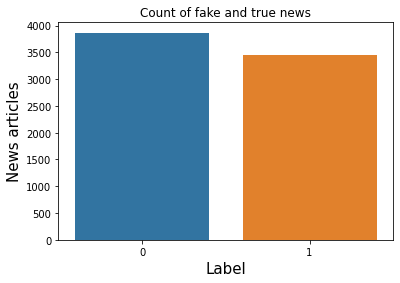

In [46]:
#Count of fake and true news
ax = sns.countplot(x = "label", data = df)

#Setting labels and font size
ax.set(xlabel = 'Label', ylabel = 'News articles', title = 'Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

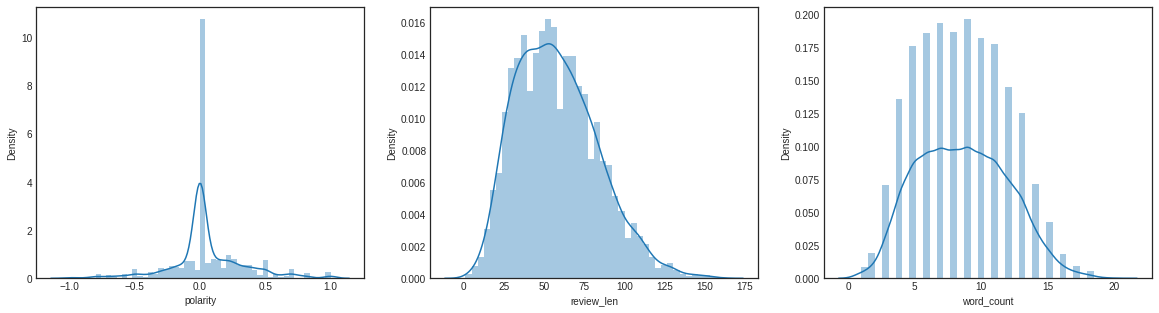

In [47]:
#Extracting the features from text
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()

In [48]:
#top n words in the dataset
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)
for word, freq in common_words:
    print(word, freq)

people 838
bi 816
bif 638
bthe 637
white 576
dont 461
person 439
like 414
bthere 409
world 384
want 368
country 365
way 358
good 310
get 293
women 284
united 263
states 260
woman 260
know 249


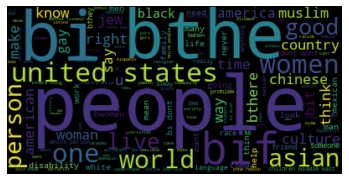

In [49]:
#word cloud for the entire dataset
text = " ".join(x for x in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'black').generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [50]:
#word embeddings using Glove
glove_gensim  = api.load('glove-wiki-gigaword-300')
vocab = glove_gensim.wv.vocab

[=================================================-] 99.9% 375.9/376.1MB downloaded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
#extracting maximum token length
maxi=-1
for i,rev in enumerate(df['text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
maxi

20

In [52]:
#tokenizing the news article
tokenizer = Tokenizer()
df_total = df['text']
tokenizer.fit_on_texts(df_total)

In [53]:
max_rev_len = maxi  
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 300

In [54]:
#padding the tokinized news articles
X_train = tokenizer.texts_to_sequences(df['text'])  
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post') 

In [55]:
vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = glove_gensim.wv.get_vector(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [56]:
#extracting embedding matrix
embed_matrix = np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i] = embed_vector

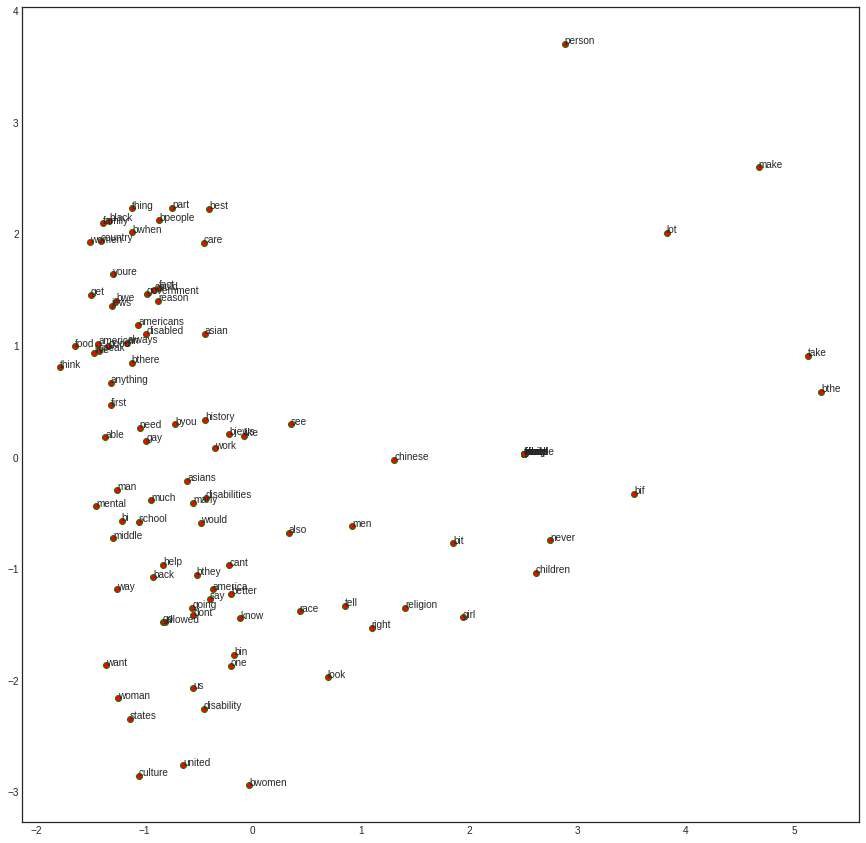

In [57]:
#PCA for visualization of word embeddings
lst = []
for i in tokenizer.word_index.keys():
  lst.append(i)
pca = PCA(n_components = 2)
np.set_printoptions(suppress = True)
P = pca.fit_transform(embed_matrix[:100])
labels = lst
plt.figure(figsize = (15, 15))
plt.scatter(P[:, 0], P[:, 1], c = 'r', edgecolors = 'g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x, y), xytext = (0, 0), textcoords = 'offset points', )